In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.special import kl_div


In [2]:
import random

random.seed(20240530)

In [3]:
import time 
import seaborn as sns

## Data Generating Process


In [4]:

## True Exposure Model and Data Generating Process 
def logistic_row(row):
    return np.exp(row) / np.sum(np.exp(row))

def dim_est(obs_T, obs_C, treated_probability, Q):
    n1,n0 = len(obs_T), len(obs_C)
    tau1 = np.sum(obs_T) / (Q*treated_probability)
    tau0 = np.sum(obs_C)/(Q * (1-treated_probability))
    estimate = tau1 - tau0
    var = np.sum((obs_T - tau1)**2)/ Q/treated_probability**2  + np.sum((obs_C - tau0)**2)/ Q/(1-treated_probability)**2 
    return estimate, var

def get_ground_truth(Q, K, promo_ratio, item_embeddings, item_promotion):
    J, d = item_embeddings.shape
    user_embeddings = np.random.uniform(size=(Q, d))
    utility = user_embeddings @ (item_embeddings.T)
    baseline_score = []
    promotions = []
    query_matrix = []
    embeddings = []
    for each_query in range(Q):
        selected_indices = np.random.choice(np.arange(J), size = K, replace= False)
        query_matrix += [selected_indices]
        promotions.append([item_promotion[ind] for ind in selected_indices])
        baseline_score.append([utility[each_query, ind] for ind in selected_indices])
        embeddings.append([np.concatenate([user_embeddings[each_query], item_embeddings[ind]]) for ind in selected_indices])
    baseline_score = np.array(baseline_score)
    promotions = np.array(promotions)
    query_matrix = np.array(query_matrix)
    embeddings = np.array(embeddings)

    outcome_potential = baseline_score
    
    final_score_matrix_treated = promo_ratio * promotions * baseline_score  + baseline_score
    final_score_matrix_control = baseline_score
    p_treated = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix_treated)
    p_control = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix_control)

    yT = np.sum(p_treated * outcome_potential, axis=1)
    yC = np.sum(p_control * outcome_potential, axis=1)
    true_estimate = np.mean(yT) - np.mean(yC)
    true_stderr = np.sqrt(np.var(yT)/ len(yT) + np.var(yC)/ len(yC))
    return true_estimate, true_stderr
    

def DGP_new_heterogeneous_embeddings(Q, K, promo_ratio, item_embeddings, item_promotion, treated_probability=0.5):
    J, d = item_embeddings.shape
    user_embeddings = np.random.uniform(size=(Q, d))
    utility = user_embeddings @ (item_embeddings.T)
    treatment_dict = np.random.choice([1, 0], J, p=[treated_probability, 1 - treated_probability])

    W_matrix = []
    baseline_score = []
    promotions = []
    query_matrix = []
    embeddings = []
    for each_query in range(Q):
        selected_indices = np.random.choice(np.arange(J), size = K, replace= False)
        query_matrix += [selected_indices]
        W_matrix.append([treatment_dict[ind] for ind in selected_indices])
        promotions.append([item_promotion[ind] for ind in selected_indices])
        baseline_score.append([utility[each_query, ind] for ind in selected_indices])
        embeddings.append([np.concatenate([user_embeddings[each_query], item_embeddings[ind]]) for ind in selected_indices])

    W_matrix = np.array(W_matrix)
    baseline_score = np.array(baseline_score)
    promotions = np.array(promotions)
    query_matrix = np.array(query_matrix)
    embeddings = np.array(embeddings)

    final_score_matrix = W_matrix * promo_ratio * promotions * baseline_score  + baseline_score

    logit = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix)
    expose_indices = np.array([np.random.choice(np.arange(K), size = 1, p = logit[i,:]) for i in range(Q)])
    inddds = np.array(list(np.arange(K)) * Q).reshape(Q,K)
    exposure_matrix = np.array([inddds[i,:] == expose_indices[i] for i in range(Q)])
    outcome_noise =  np.random.normal(size=(Q, K)) 
    
    ## Outcome model  
    ## First: a true outcome model of Exponential 
    outcome_potential = baseline_score

    return query_matrix, promotions, embeddings, W_matrix, outcome_potential, exposure_matrix

In [5]:
## Number of videos 
J = 500 
## Consideration set size 
K = 3 
## Generate some queries along with the recommendation model 
Q = 1000

np.random.seed(1)

d = 2
item_embeddings = np.random.uniform(size=(J, d))
item_promotion = np.random.choice([1, 0], size=J)



results_df = pd.DataFrame()
dim_B, dim_var_B = [], []

In [20]:
## Number of MC simulations
B = 800

treated_probability = 0.5

for uplift_ratio in np.linspace(-0.5, 0.5, 11):
    print(f"Start K = {K}, Q = {Q}, J = {J}, uplift_ratio = {uplift_ratio}")
    # Ground truth
    true_estimate, true_stderr = get_ground_truth(Q * 100, K, uplift_ratio, item_embeddings, item_promotion)
    
    truth.append(true_estimate)
    print(f"True ATE {true_estimate} ({true_stderr})")

    # DIM
    dim_b, dim_var_b= [],[]

    ## True Outcome Model test 
    for b in range(B):
        if b % 100 == 0:
            print(b)
        ## DGP and data pre-processing 
        (query_matrix, promotions, embeddings, W_matrix, 
         outcome_potential, exposure_matrix) = DGP_new_heterogeneous_embeddings(Q, K, uplift_ratio, item_embeddings, item_promotion, treated_probability=0.5)
        observed_outcome = np.sum(outcome_potential * exposure_matrix, axis = 1 )
        observed_queries_treatment = np.sum(exposure_matrix * W_matrix, axis = 1 )
        T, C = observed_outcome[observed_queries_treatment == 1] , observed_outcome[observed_queries_treatment == 0]  
        
        dim_point, dim_var = dim_est(T, C, treated_probability, Q)
        dim_b += [dim_point]
        dim_var_b += [dim_var]


    df = pd.DataFrame({"dim": dim_b, "dim_var":dim_var_b, "J" : J,"Q": Q, "K":K, "uplift_ratio":uplift_ratio, "true_estimate": true_estimate, "true_stderr": true_stderr})
    results_df = pd.concat([df, results_df])
    # result_df.to_csv("result2405new/new_heterogeneous_{}_synthetic_ab_j{}q{}k{}_100_{}.csv".format(str(int(time.time())),str(J), str(Q), str(K), str(uplift_ratio).replace('.','')))
    # plt.figure() 
    # # plt.hist(dim_B)
    # sns.histplot(result_df, x='dim', stat='density')
    
    # #sns.kdeplot(np.array(dim_B) / np.sqrt(np.array(dim_var_B)), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
    # # plt.plot(x, y_standard_normal, color='black', label="Standard Normal", ls='--')
    # plt.legend()
    print(f"DIM mean {np.mean(dim_b)} stderr {np.std(dim_b)/np.sqrt(B)}")
    dim_B.append(dim_b)
    dim_var_B.append(dim_var_b)

Start K = 3, Q = 1000, J = 500, uplift_ratio = -0.5
True ATE -0.009114755386819384 (0.0011799430758526242)
0
100
200
300
400
500
600
700
DIM mean -0.06366806783721927 stderr 0.0024740069599152956
Start K = 3, Q = 1000, J = 500, uplift_ratio = -0.4
True ATE -0.007402594424185227 (0.001175264952382825)
0
100
200
300
400
500
600
700
DIM mean -0.04979939443572684 stderr 0.00231430501970062
Start K = 3, Q = 1000, J = 500, uplift_ratio = -0.3
True ATE -0.00547736794573872 (0.0011726507349583224)
0
100
200
300
400
500
600
700
DIM mean -0.03318419131306526 stderr 0.002383974539074281
Start K = 3, Q = 1000, J = 500, uplift_ratio = -0.19999999999999996
True ATE -0.003679181556698219 (0.0011780353460268372)
0
100
200
300
400
500
600
700
DIM mean -0.023021802912598113 stderr 0.002378080134206793
Start K = 3, Q = 1000, J = 500, uplift_ratio = -0.09999999999999998
True ATE -0.0018441947226967015 (0.0011855719361883476)
0
100
200
300
400
500
600
700
DIM mean -0.010060785323402315 stderr 0.00234771168

In [21]:
results_df['DIM Bias'] = ['Positive Bias' if r > 0 else 'Negative Bias' for r in results_df['uplift_ratio']]

In [22]:
results_df.query("uplift_ratio==0.5")

,dim,dim_var,J,Q,K,uplift_ratio,true_estimate,true_stderr,DIM Bias
0,-0.091213,0.439344,500,1000,3,0.5,0.008939,0.001198,Positive Bias
1,-0.089461,0.407675,500,1000,3,0.5,0.008939,0.001198,Positive Bias
2,0.097210,0.447776,500,1000,3,0.5,0.008939,0.001198,Positive Bias
3,0.006394,0.430932,500,1000,3,0.5,0.008939,0.001198,Positive Bias
4,0.099108,0.430972,500,1000,3,0.5,0.008939,0.001198,Positive Bias
...,...,...,...,...,...,...,...,...,...
95,0.052796,0.419229,500,1000,3,0.5,0.008935,0.001202,Positive Bias
96,0.124958,0.404469,500,1000,3,0.5,0.008935,0.001202,Positive Bias
97,0.052367,0.427075,500,1000,3,0.5,0.008935,0.001202,Positive Bias
98,0.034609,0.415839,500,1000,3,0.5,0.008935,0.001202,Positive Bias


In [23]:
results_df.to_csv("PaperResult/dim_bias.csv")

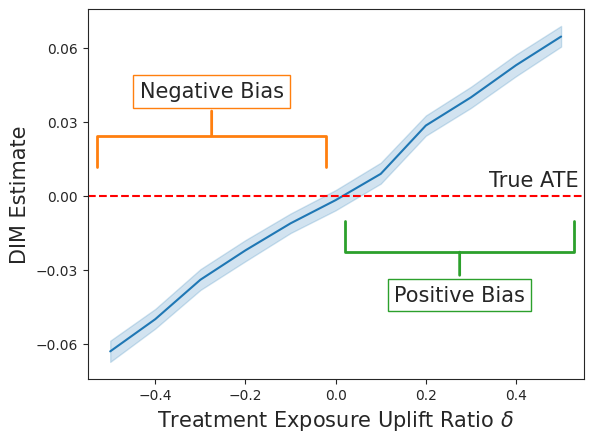

In [27]:
sns.set_style("ticks")
ax = sns.lineplot(data=results_df, x="uplift_ratio", y="dim")
c = sns.color_palette()
ax.annotate('Negative Bias', xy=(0.25, 0.65), xytext=(0.25, 0.75), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color=c[1]),
            arrowprops=dict(arrowstyle="-[, widthB=5.5, lengthB=1.5", lw=2.0, color=c[1]))

ax.annotate('Positive Bias', xy=(0.75, 0.35), xytext=(0.75, 0.2), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color=c[2]),
            arrowprops=dict(arrowstyle="-[, widthB=5.5, lengthB=1.5", lw=2.0, color=c[2]))
ax.set_xlabel("Treatment Exposure Uplift Ratio $\delta$", fontsize=15)
ax.set_ylabel("DIM Estimate", fontsize=15)
ax.axhline(y=0.0, ls='--', c='r')
ax.annotate('True ATE', xy=(0.75, 0.35), xytext=(0.9, 0.51), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom')
ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.06, -0.03, 0, 0.03, 0.06])
plt.savefig("PaperResult/dim_bias.pdf")